# Constructing a macronova model using sncosmo

Required ingredients:
* SED for a set of phases, split into 3 numpy arrays:
 * phase: shape N
 * wavelength: shape M
 * flux: shape NxM
 
To use this notebook, please download the [macronova template](http://www.oir.caltech.edu/twiki_ptf/bin/viewfile/ZTF/SNeIa?rev=1;filename=mn_runB_sed.dat) from the ZTF Twiki and place it in notebooks/data/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sncosmo


In [2]:
mn_sed = np.genfromtxt('data/mn_runB_sed.dat')
phase = np.unique(mn_sed[:,0])
wave = mn_sed[mn_sed[:,0] == 0][:,1]
flux = np.array([mn_sed[mn_sed[:,0] == p][:,2] for p in phase])

Use these arrays to define a source which then defines a model

In [3]:
source = sncosmo.TimeSeriesSource(phase, wave, flux)
model = sncosmo.Model(source=source)

print model.param_names
print model.parameters

['z', 't0', 'amplitude']
[ 0.  0.  1.]


Such a model only has three parameter (see above). 

To get magnitudes first set redshift and peak absolute magnitude.

Model parameter "amplitude" now set to: 1.17811524042e-22


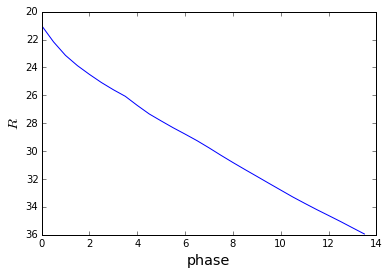

In [4]:
model.set(z=0.01)
model.set_source_peakabsmag(-12.2, 'bessellr', 'vega')

print 'Model parameter "amplitude" now set to:', model.parameters[2] 

mag = model.bandmag('bessellr', 'vega', phase)
plt.plot(phase, mag)
plt.xlabel('phase',fontsize='x-large')
plt.ylabel(r'$R$',fontsize='x-large')
plt.gca().invert_yaxis()

You can also include the effect of Milk Way dust when defining the model.

In [5]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source=source,
                      effects=[dust],
                      effect_names=['mw'],
                      effect_frames=['obs'])

print model.param_names
print model.parameters

['z', 't0', 'amplitude', 'mwebv', 'mwr_v']
[ 0.   0.   1.   0.   3.1]


This added two new parameters: $E(B-V)$ and $R_V$.

Note that astrobject checks for these parameters before using a model and adds the effect if necessary. $E(B-V)$ will automatically be read from the SFD98 dust maps.

We can also include the same effect in restframe to add host extinction.

In [6]:
model = sncosmo.Model(source=source,
                      effects=[dust,dust],
                      effect_names=['mw', 'host'],
                      effect_frames=['obs', 'rest'])

print model.param_names
print model.parameters

['z', 't0', 'amplitude', 'mwebv', 'mwr_v', 'hostebv', 'hostr_v']
[ 0.   0.   1.   0.   3.1  0.   3.1]


## Using the macronova model in a simulated survey

sncosmo sources/models can be passed to astrobject.TransientGenerator and then used like the SNIaGenerator in survey_plan_and_lightcurves.ipynb

In addition to the source/model you just need to define a function that draws the lightcurve parameters. This function expects to get the redshifts and the lightcurve model as arguments. The latter is needed, so you can set the peak magnitude.

In [7]:
def _random_mn_amplitude(redshifts, model, **kwargs):
    amp = []
    for z in redshifts:
        model.set(z=z)
        mabs = np.random.normal(-12.2, 2.0)
        model.set_source_peakabsmag(mabs, 'bessellr', 'ab')
        amp.append(model.get('amplitude'))

    return {'amplitude': np.array(amp)}

Now create a TransientGenerator with a custom rate of $3\cdot10^{-7}$ Mpc$^{-3}$ yr$^{-1}$ and the macronova template. The rate should be passed as a function of redshift (even if it is constant). The default survey time range is set to 3 years.

In [8]:
import simsurvey.cadence as simul
tr = simul.get_transient_generator([0.0, 1.0], ratekind='custom', ratefunc=lambda z: 3e-7, 
                                   transientprop=dict(lcsource=source,lcsimul_func=_random_mn_amplitude))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x10adc5750>,
 'cbar': <matplotlib.colorbar.Colorbar instance at 0x10adbc6c8>,
 'figure': <matplotlib.figure.Figure at 0x10adc5050>,
 'plot': <matplotlib.collections.PathCollection at 0x10de56810>}

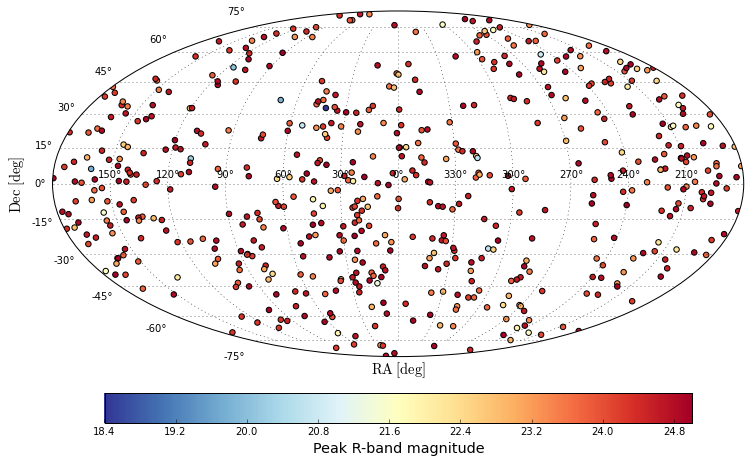

In [9]:
# Plot of generated MNe (make cut at R = 25, leaving ~500 MNe)
peak_mag = tr.get_bandmag(band='bessellr', magsys='vega', t=0) # t is time relative to t0
tr.show_skycoverage(cscale=peak_mag, cblabel="Peak R-band magnitude", vmin=None, vmax=25, mask=(peak_mag < 25))

In [10]:
# There are only few MNe at R < 21 (Remember that this is for observing everything out to z = 1.0 for three years.) 
for R in np.arange(18,25.1,0.5):
    print 'R < {}: {:>5} MNe'.format(R, np.sum(peak_mag < R))
   
print '-------------------'
print 'total:    {:>5} MNe'.format(len(peak_mag))

R < 18.0:     0 MNe
R < 18.5:     1 MNe
R < 19.0:     1 MNe
R < 19.5:     1 MNe
R < 20.0:     3 MNe
R < 20.5:     5 MNe
R < 21.0:     9 MNe
R < 21.5:    11 MNe
R < 22.0:    22 MNe
R < 22.5:    38 MNe
R < 23.0:    65 MNe
R < 23.5:   118 MNe
R < 24.0:   204 MNe
R < 24.5:   331 MNe
R < 25.0:   562 MNe
-------------------
total:    81140 MNe
